In [1]:
# load my pretrained model

In [2]:
import tensorflow as tf
from tensorflow import keras

In [22]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [23]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat","Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [31]:
len(y_train_full)

60000

In [3]:
!ls

Complex Models using Functional API.ipynb
MLP -Classification using Sequential API.ipynb
MLP Regression - Sequential API.ipynb
Notes
Transfer Learning.ipynb
my_logs
saved_classification_model


In [4]:
model_A = keras.models.load_model('saved_classification_model')

In [6]:
model_A.layers

Reusing pretrained layers
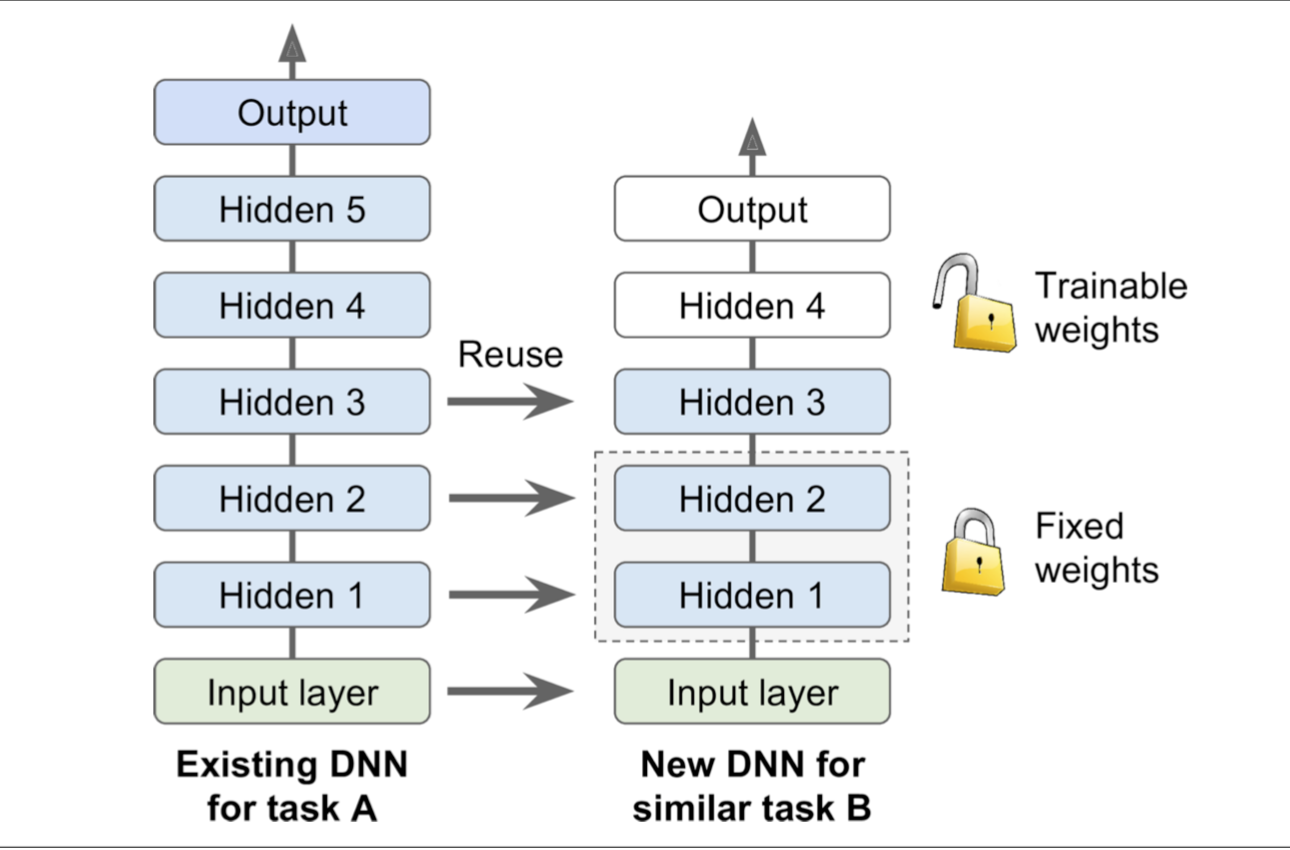

In [ ]:
# Using the below code would change the weights of the pretrained models, which we don't want to do. 
# model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
# model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [7]:
# Clone the model and copy the weights (since clone doesn't copy the weights)
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

TypeError: ('Keyword argument not understood:', 'data_format')

There are issues when cloning a model that is from a SavedModelFormat. So I have saved the model with h5 and given it a retry

In [10]:
model_A_h5 = keras.models.load_model('saved_classification_model_h5form.h5')

In [12]:
model_A_h5clone = keras.models.clone_model(model_A_h5)
model_A_h5clone.set_weights(model_A_h5.get_weights())

In [14]:
model_A_h5.layers[:-1]

In [15]:
# Add those pretrained layers to the new model, Removed the last layer and added a new task

model_B_on_A = keras.models.Sequential(model_A_h5.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [16]:
model_B_on_A.layers

In [18]:
# Freezing the lower layers, since the start of the training would mess it up.
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

In [20]:
model_B_on_A.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.SGD(),metrics = [keras.metrics.Accuracy()] )

Now you can train the model for a few epochs, then unfreeze the reused layers (which requires compiling the model again) and continue training to fine-tune the reused layers for task B. After unfreezing the reused layers, it is usually a good idea to reduce the learning rate, once again to avoid damaging the reused weights

In [ ]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                               validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]: 
    layer.trainable = True
    
optimizer = keras.optimizers.SGD(lr=1e-4) # the default lr is 1e-2 

model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                         metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Transfer learning does not work very well with small dense networks,